### N.Harsha Vardhan
### Roll:2019101122

In [4]:
import numpy as np
import cv2
import os
import itertools
import random
import pickle
import matplotlib.pyplot as plt
import glob

In [5]:
world_cordinates = 36 * np.array([
    [0, 1, 0],
    [0, 2, 0],
    [1, 1, 0],
    [1, 2, 0],
    [2, 1, 0],
    [2, 2, 0],
    [3, 1, 0],
    [3, 2, 0],
    [0, 0, 1],
    [0, 0, 2],
    [1, 0, 1],
    [1, 0, 2],
    [2, 0, 1],
    [2, 0, 2],
    [3, 0, 1],
    [3, 0, 2],
    [4, 1, 0],
    [4, 2, 0],
    [5, 1, 0],
    [5, 2, 0],
    [6, 1, 0],
    [6, 2, 0],
    [4, 0, 1],
    [4, 0, 2],
    [5, 0, 1],
    [5, 0, 2],
    [0, 0, 3],
    [0, 0, 4],
    [1, 0, 3],
    [1, 0, 4],
    [2, 0, 3],
    [2, 0, 4],
    [3, 0, 3],
    [3, 0, 4],
    [4, 0, 3],
    [4, 0, 4]
])

image_cordinates = np.array([
    [4868.3, 1389.7],
    [4916.2, 560.2],
    [4030.0, 1333.6],
    [4058.9, 514.9],
    [3221.3, 1275.5],
    [3237.1, 467.6],
    [2437.6, 1218.4],
    [2434.0, 423.5],
    [4726.3, 2456.3],
    [4638.2, 2787.5],
    [3864.2, 2378.0],
    [3723.8, 2711.5],
    [3030.9, 2306.0],
    [2841.3, 2632.3],
    [2222.2, 2233.3],
    [1985.3, 2546.7],
    [1672.7, 1162],
    [1654.0, 374.7],
    [927, 1105.5],
    [892, 325.5],
    [194.2, 1048.8],
    [135.3, 282.0],
    [1432.5, 2159.0],
    [1148.3, 2461.7],
    [659.5, 2100.8],
    [329.7, 2397.7],
    [4539.0, 3161.0],
    [4425.7, 3600],
    [3564.0, 3076],
    [3384.5, 3492.5],
    [2625.3, 2992.3],
    [2378.7, 3398.7],
    [1713.3, 2908.7],
    [1409.0, 3308.7],
    [831.0, 2813.5],
    [466.0, 3217.3]
])


world_cord_dlt=np.array([[0,0,36],    [36,0,36],  [144,0,72], [72,0,108], [108,36,0],[180,72,0],[36,36,0],[72,36,0],[72,0,36]])
image_cord_dlt =np.array([[4730,2450],[3860,2370],[1160,2470],[2620,3010],[2440,1230],[890,340],[4030,1340],[3230,1270],[3040,2320]])

def imageview():
    img = cv2.imread('../data/measurements.jpg')
    img = cv2.resize(img,(547,364))
    cv2.imshow("black-dots",img)
    cv2.waitKey(0)
    cv2.destroyAllWindows()


def imageview1():
    img = cv2.imread("../data/mycam/dots.jpg")
    img_sz = img.shape
    img = cv2.resize(img,(int(img_sz[1]/10),int(img_sz[0]/10)))

    cv2.imshow("Own cam",img)
    cv2.waitKey(0)
    cv2.destroyAllWindows() 
def error(P,world_cord,image_cord):
    world_cord = np.concatenate((world_cord,np.ones((world_cord.shape[0],1))),axis=1)
    pred = P @ (world_cord.T)
    pred = pred[:2][:]/pred[2][:]
    pred = pred.T

    diff = pred - image_cord

    return np.linalg.norm(diff)

def decompose_matrix(P_matrix):
    M = P_matrix[:,:3]
    MC= -1* P_matrix[:,3]
    C = np.linalg.inv(M) @ MC
    R,K = np.linalg.qr(M)
    return K, R ,C



### Q1.Implement the DLT (Direct Linear Transformation) based calibration

In [6]:

# using the inverse method
def dltcalibration_inv(world_cord,img_cord):
    num = world_cord.shape[0]
    X  = np.zeros((2*num,11))
    Y= np.zeros((2*num,1))
    it=0
    for (wc,ic) in zip(world_cord,img_cord):
        X[it]=np.array([wc[0], wc[1], wc[2], 1, 0, 0, 0, 0, -ic[0]*wc[0], -ic[0]*wc[1], -ic[0]*wc[2]])
        X[it+1]=np.array([0, 0, 0, 0, wc[0], wc[1], wc[2], 1, -ic[1]*wc[0], -ic[1]*wc[1], -ic[1]*wc[2]])
        Y[it]=np.array([ic[0]])
        Y[it+1]=np.array([ic[1]])
        it+=2
    
    #L = (np.linalg.inv((X.T)@X) @ (X.T) ) @ Y 
    L = np.linalg.pinv(X)@Y
    L = np.concatenate((L,np.array([[1]])),axis=0)
    L= np.reshape(L,(3,4))
    return L


# using svd
def dltcalibration_svd(world_cord,img_cord):
    num = world_cord.shape[0]
    X  = np.zeros((2*num,12))

    it=0
    for (wc,ic) in zip(world_cord,img_cord):
        X[it]=np.array([wc[0], wc[1], wc[2], 1, 0, 0, 0, 0, -ic[0]*wc[0], -ic[0]*wc[1], -ic[0]*wc[2],-ic[0]])
        X[it+1]=np.array([0, 0, 0, 0, wc[0], wc[1], wc[2], 1, -ic[1]*wc[0], -ic[1]*wc[1], -ic[1]*wc[2],-ic[1]])
        it+=2
    
    U,S,VT=np.linalg.svd(X)
    V=VT.T
    Mtemp=V[:,V.shape[1]-1]
    M=np.zeros((3,4))
    M[0,:]=Mtemp[:4]
    M[1,:]=Mtemp[4:8]
    M[2,:]=Mtemp[8:12]
    return M


### Q2.Implement the RANSAC based variant of the calibration

In [7]:
def ransac_callibration(world_cord,img_cord,test_wc,test_ic,iter=400):
    P_best = None
    err_min = 9999999
    num=world_cord.shape[0]
    for i in range(2):
        randomlist = random.sample(range(0, num), 6)
        wc = world_cord[randomlist]
        ic = img_cord[randomlist]
        P_cur = dltcalibration_inv(world_cord,img_cord)
        err_cur = error(P_cur,test_wc,test_ic)
        if err_cur <err_min:
            P_best = P_cur
            err_min=err_cur
        
    return  P_best

### Q3.Using the image given and real world measurements, Compute the camera’s internal and external parameters using each of the above algorithms

In [8]:
P_matrix_dlt = dltcalibration_inv(world_cord_dlt,image_cord_dlt)
P_matrix_ransac= ransac_callibration(world_cordinates,image_cordinates,world_cord_dlt,image_cord_dlt)

test_wc = np.array([[0,0,108], [0,0,72], [36,0,72], [36,0,108], [0,0,36], [36,0,36], [0,36,0], [36,36,0]])
test_ic = np.array([[4548,3186], [4652,2805], [3782,2724], [3578, 3093], [4733,2470], [3867,2389], [4883,1408], [4040, 1362]]) 
 
print(int(error(P_matrix_dlt,test_wc,test_ic)),int(error(P_matrix_ransac,test_wc,test_ic)))

k1,r1,c1 = decompose_matrix(P_matrix_dlt)
k2,r2,c2 = decompose_matrix(P_matrix_ransac)
print("K,R,C using dlt method:")
print(k1,r1,c1)
print("K,R,C using ransac method:")
print(k2,r2,c2)


107 89
K,R,C using dlt method:
[[ 2.01918175e+01  4.32268490e+00  1.09286536e+01]
 [ 0.00000000e+00  2.33025292e+01 -3.40637238e+00]
 [ 0.00000000e+00  0.00000000e+00 -2.57071606e-03]] [[-9.99336959e-01  3.64093736e-02  2.63931017e-05]
 [-3.64093751e-02 -9.99336957e-01 -5.93932204e-05]
 [ 2.42131320e-05 -6.03147966e-05  9.99999998e-01]] [ -0.64761194 141.91534039 388.01275295]
K,R,C using ransac method:
[[ 2.10570761e+01  2.79538730e+00  9.42734882e+00]
 [ 0.00000000e+00  2.23656696e+01 -4.83857014e+00]
 [ 0.00000000e+00  0.00000000e+00 -1.90048543e-03]] [[-9.98558040e-01  5.36827826e-02  1.76474986e-05]
 [-5.36827831e-02 -9.98558039e-01 -3.04040819e-05]
 [ 1.59898759e-05 -3.13076073e-05  9.99999999e-01]] [-33.7298135  200.83407322 536.203928  ]



- Collected 2d values of points manually by displaying image using  cv2.imshow()
- Used pinv which computes pseudo inverse if inverse doesn't exists.
- Ransac is run 400 iterations.Ransac performed better as compared to dlt.

### Q5.Draw Overlays using P matrices obtained from above callibrations     

Text(0.5, 1.0, 'RANSAC_Wireframe')

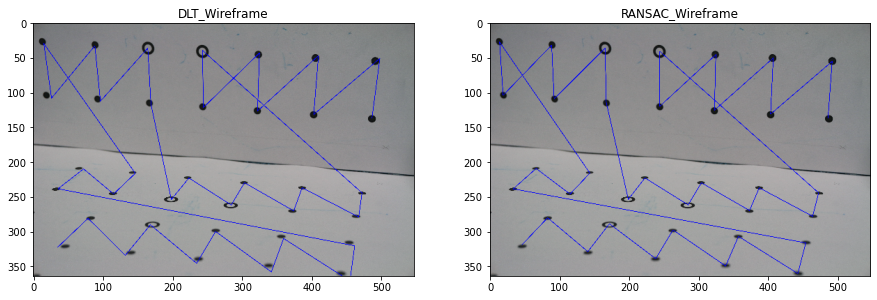

In [9]:
plt.figure(figsize=(15,15))
world_cordinates_homo = np.concatenate((world_cordinates,np.ones((world_cordinates.shape[0],1))),axis=1)

predicted_cordinates_dlt = P_matrix_dlt @ (world_cordinates_homo.T)
predicted_cordinates_dlt = predicted_cordinates_dlt[:2][:]/predicted_cordinates_dlt[2][:]
predicted_cordinates_dlt = predicted_cordinates_dlt.T


points = predicted_cordinates_dlt.reshape((-1,1,2))
img = cv2.imread('../data/black-dots.JPG')
cv2.polylines(img,np.int32([points]) ,isClosed=False,color=(0,0,255),thickness=8,lineType=cv2.LINE_AA)
img = cv2.resize(img,(547,364))
plt.subplot(1,2,1)
plt.imshow(img)
plt.title('DLT_Wireframe')


predicted_cordinates_ransac = P_matrix_ransac @ (world_cordinates_homo.T)
predicted_cordinates_ransac = predicted_cordinates_ransac[:2][:]/predicted_cordinates_ransac[2][:]
predicted_cordinates_ransac = predicted_cordinates_ransac.T


points = predicted_cordinates_ransac.reshape((-1,1,2))
img = cv2.imread('../data/black-dots.JPG')
cv2.polylines(img,np.int32([points]) ,isClosed=False,color=(0,0,255),thickness=8,lineType=cv2.LINE_AA)
img = cv2.resize(img,(547,364))

plt.subplot(1,2,2)
plt.imshow(img)
plt.title('RANSAC_Wireframe')

### Q6.Repeat the calibration of the camera using Zhang’s method

In [10]:
dimens = (8,6)

criteria = (cv2.TERM_CRITERIA_EPS +
            cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)

objectp3d = np.zeros((1, dimens[0]* dimens[1],3), np.float32)
objectp3d[0, :, :2] = np.mgrid[0:dimens[0], 0:dimens[1]].T.reshape(-1, 2)

twodpoints =[]
threedpoints =[]

image_paths = glob.glob('../data/checkerboard*.JPG')

image_size = cv2.imread( image_paths[0]).shape[:2]


def get_2d_points(img):
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    ret, corners = cv2.findChessboardCorners(gray,dimens,None)
    if ret == True:
        corners2 = cv2.cornerSubPix(gray,corners,(11,11),(-1,-1),criteria)
        return corners2
    else:
        return None


def zhangs_callibration(image_paths,debug = False):
    for img in image_paths:
        img = cv2.imread(img)
        corners2 = get_2d_points(img)
        if corners2 is not None:
            threedpoints.append(objectp3d)
            twodpoints.append(corners2)
            #img = cv2.drawChessboardCorners(img,dimens,corners2,True )
        if(debug):
            img = cv2.resize(img,(int((image_size[1]/10)),int(image_size[0]/10)))
            cv2.imshow('img',img)
            cv2.waitKey(0)

    cv2.destroyAllWindows()
    ret, mtx, distcoeff, rvecs, tvecs = cv2.calibrateCamera(threedpoints, twodpoints,image_size, None, None)   
    if ret:
        return mtx ,distcoeff,rvecs,tvecs
    else:
        return None

camera_matrix_zhang,distcoeff,rvecs,tvecs = zhangs_callibration(image_paths)

### Q7.Repeat the overlay of wireframe using the internal parameters estimated from Zhang’s method

Text(0.5, 1.0, 'Zhang_Wireframe')

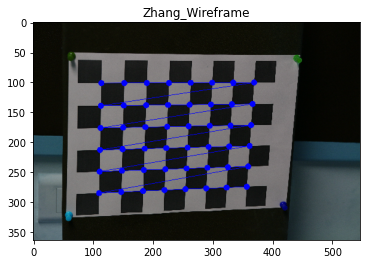

In [11]:
predicted_cordinates_zhang = cv2.projectPoints(threedpoints[-1],rvecs[-1],tvecs[-1],camera_matrix_zhang,distcoeff)
predicted_cordinates_zhang = predicted_cordinates_zhang[0]
img = cv2.imread(image_paths[-1])

for x,y in predicted_cordinates_zhang.reshape(-1,2):
    img = cv2.circle(img,(int(x),int(y)),50,(0,0,255),-1)
cv2.polylines(img,np.int32([predicted_cordinates_zhang]) ,isClosed=False,color=(0,0,255),thickness=8,lineType=cv2.LINE_AA)
img = cv2.resize(img,(547,364))

plt.imshow(img)
plt.title('Zhang_Wireframe')


- Zhang method callibration gave even more accurate results , as we can see almost all the intersection points are correctly predicted as shown in wireframe

### Q4.Distortion

Text(0.5, 1.0, 'After Correction For distortion')

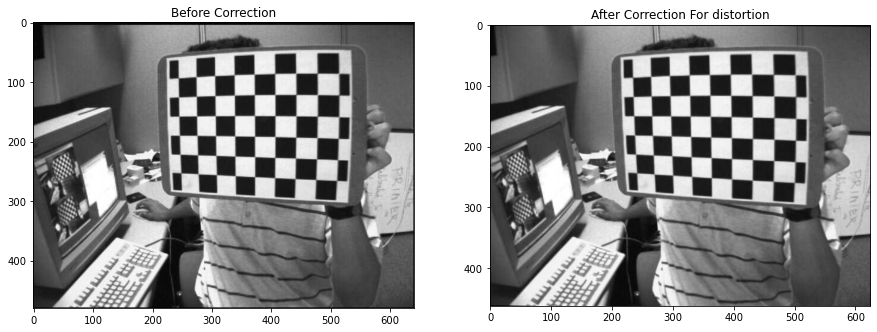

In [22]:
img = cv2.imread("../data/left01.jpg")
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.imshow(img)
plt.title("Before Correction")

h,w = img.shape[:2]
newcameramtx, roi = cv2.getOptimalNewCameraMatrix(camera_matrix_zhang, distcoeff, (w,h), 1, (w,h))
dst = cv2.undistort(img, camera_matrix_zhang, distcoeff, None, newcameramtx)

x, y, w, h = roi
dst = dst[y:y+h, x:x+w]
plt.subplot(1,2,2)
plt.imshow(dst)
plt.title("After Correction For distortion")

### Q8.What is the image of the world origin, given the calibration matrix? Does this result bear out in your observations?


(4765, 2160) (4797, 2157)


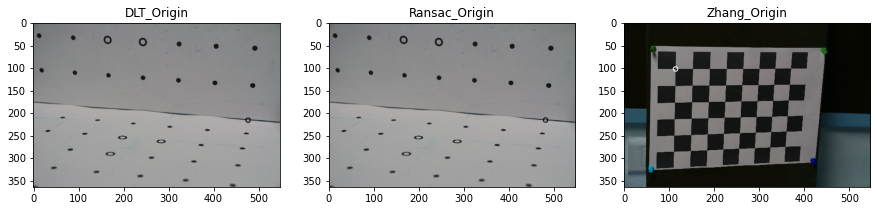

In [13]:
plt.figure(figsize=(15,15))
sample_world_orgin = np.array([[0,0,0,1]])

predicted_origin_dlt = P_matrix_dlt @ (sample_world_orgin.T)
predicted_origin_dlt = ( predicted_origin_dlt[:2][:]/predicted_origin_dlt[2][:]).T

center_dlt = (int(predicted_origin_dlt[0][0]),int(predicted_origin_dlt[0][1]))
img = cv2.imread('../data/black-dots.JPG')
img = cv2.circle(img,center_dlt,50,(0,0,0),thickness=20)
img = cv2.resize(img,(547,364))

plt.subplot(1,3,1)
plt.imshow(img)
plt.title("DLT_Origin")

predicted_origin_ransac = P_matrix_ransac @ (sample_world_orgin.T)
predicted_origin_ransac = ( predicted_origin_ransac[:2][:]/predicted_origin_ransac[2][:]).T

center_ransac = (int(predicted_origin_ransac[0][0]),int(predicted_origin_ransac[0][1]))
img = cv2.imread('../data/black-dots.JPG')
img = cv2.circle(img,center_ransac,50,(0,0,0),thickness=20)
img = cv2.resize(img,(547,364))
plt.subplot(1,3,2)
plt.imshow(img)
plt.title("Ransac_Origin")




tmp = np.array([[0, 0, 0]], dtype=np.float)
predicted_origin_zhang = cv2.projectPoints(tmp,rvecs[-1],tvecs[-1],camera_matrix_zhang,distcoeff)
predicted_origin_zhang = predicted_cordinates_zhang[0]
center_zhang = (int(predicted_origin_zhang[0][0]),int(predicted_origin_zhang[0][1]))
img = cv2.imread(image_paths[-1])
img = cv2.circle(img,center_zhang,50,(255,255,255),thickness=20)
img = cv2.resize(img,(547,364))
plt.subplot(1,3,3)
plt.imshow(img)
plt.title("Zhang_Origin")

print(center_dlt,center_ransac)

- All the three callibrations seems to have correctly detected world origin, there is very slight difference in dlt vs ransac and zhang's world is chessboard

### Q9&10. Use your own camera and compute above callibrations

[[6.24628554e+03 0.00000000e+00 1.53013366e+03]
 [0.00000000e+00 6.45629621e+03 2.90927322e+03]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]


Text(0.5, 1.0, 'Zhang_Wireframe_Own_Camera')

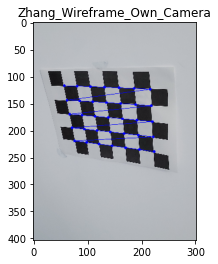

In [14]:
dimens = (7,5)

criteria = (cv2.TERM_CRITERIA_EPS +
            cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)

objectp3d = np.zeros((1, dimens[0]* dimens[1],3), np.float32)
objectp3d[0, :, :2] = np.mgrid[0:dimens[0], 0:dimens[1]].T.reshape(-1, 2)

twodpoints =[]
threedpoints =[]

image_paths = glob.glob('../data/mycam/2022*.jpg')


image_size = cv2.imread( image_paths[0]).shape[:2]
camera_matrix_zhang_mycam,distcoeff,rvecs,tvecs = zhangs_callibration(image_paths)
print(camera_matrix_zhang_mycam)

predicted_cordinates_zhang = cv2.projectPoints(threedpoints[-1],rvecs[-1],tvecs[-1],camera_matrix_zhang_mycam,distcoeff)
predicted_cordinates_zhang = predicted_cordinates_zhang[0]
img = cv2.imread(image_paths[-1])

for x,y in predicted_cordinates_zhang.reshape(-1,2):
    img = cv2.circle(img,(int(x),int(y)),25,(0,0,255),-1)

cv2.polylines(img,np.int32([predicted_cordinates_zhang]) ,isClosed=False,color=(0,0,255),thickness=8,lineType=cv2.LINE_AA)
img_sz = img.shape
img = cv2.resize(img,(int(img_sz[1]/10),int(img_sz[0]/10)))
plt.imshow(img)
plt.title('Zhang_Wireframe_Own_Camera')

In [15]:
ic = twodpoints[-1].reshape(-1,2)
wc = threedpoints[-1].reshape(-1,3)

In [16]:
P_matrix_mycam_dlt = dltcalibration_inv(wc[:8],ic[:8])
P_matrix_mycam_ransac = ransac_callibration(wc[4:] ,ic[4:],wc[:4],ic[:4])

Text(0.5, 1.0, 'RANSAC_Wireframe')

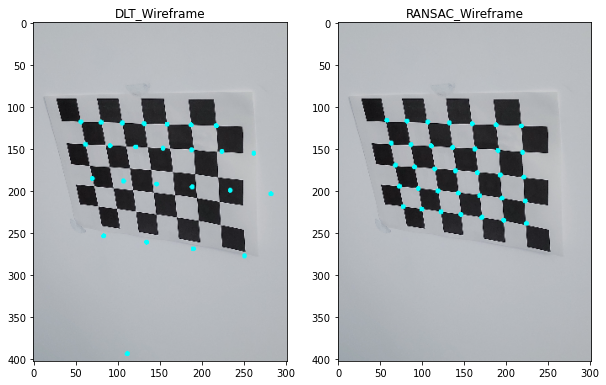

In [17]:

wc_homo= np.concatenate((wc,np.ones((wc.shape[0],1))),axis=1)

plt.figure(figsize=(10,10))
predicted_cordinates_dlt = P_matrix_mycam_dlt @ (wc_homo.T)
predicted_cordinates_dlt = predicted_cordinates_dlt[:2][:]/predicted_cordinates_dlt[2][:]
predicted_cordinates_dlt = predicted_cordinates_dlt.T


points = predicted_cordinates_dlt.reshape((-1,1,2))
img = cv2.imread(image_paths[-1])
for x,y in predicted_cordinates_dlt.reshape(-1,2):
    img = cv2.circle(img,(int(x),int(y)),30,(0,255,255),-1)

#cv2.polylines(img,np.int32([points]) ,isClosed=False,color=(0,0,255),thickness=8,lineType=cv2.LINE_AA)
img_sz = img.shape
img = cv2.resize(img,(int(img_sz[1]/10),int(img_sz[0]/10)))
plt.subplot(1,2,1)
plt.imshow(img)
plt.title('DLT_Wireframe')



predicted_cordinates_ransac = P_matrix_mycam_ransac @ (wc_homo.T)
predicted_cordinates_ransac = predicted_cordinates_ransac[:2][:]/predicted_cordinates_ransac[2][:]
predicted_cordinates_ransac = predicted_cordinates_ransac.T


points = predicted_cordinates_ransac.reshape((-1,1,2))
img = cv2.imread(image_paths[-1])
for x,y in predicted_cordinates_ransac.reshape(-1,2):
    img = cv2.circle(img,(int(x),int(y)),30,(0,255,255),-1)

#cv2.polylines(img,np.int32([points]) ,isClosed=False,color=(0,255,255),thickness=8,lineType=cv2.LINE_AA)
img_sz = img.shape
img = cv2.resize(img,(int(img_sz[1]/10),int(img_sz[0]/10)))

plt.subplot(1,2,2)
plt.imshow(img)
plt.title('RANSAC_Wireframe')

- Dlt method callibration did not work well while ransac and zhang gave accurate predictions of points (from woreframes)